<a href="https://colab.research.google.com/github/NeoRedcraft/nlp-project-1/blob/Qwen%2FQwen3-0.6B/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 1: Introduction to the Problem

# Section 2: Dataset Description

## Section 2.1: Brief Description

[Provide a brief description of the knowledge sources used (e.g., PDFs, web pages, text
files, databases).]

## Section 2.2: Source of Documents

[State the source of the documents and how they were collected. ]

## Section 2.3: Dataset Structure

[Explain the dataset structure (number of documents, file types, size, domains).]

In [9]:
# Clone the GitHub repository
!git clone https://github.com/NeoRedcraft/nlp-project-1

Cloning into 'nlp-project-1'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 91 (delta 38), reused 32 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (91/91), 1.41 MiB | 6.69 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [10]:
%cd nlp-project-1

/content/nlp-project-1


/tmp/ipython-input-2473/3456169558.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tfidf_sum.values, y=tfidf_sum.index, palette='viridis')


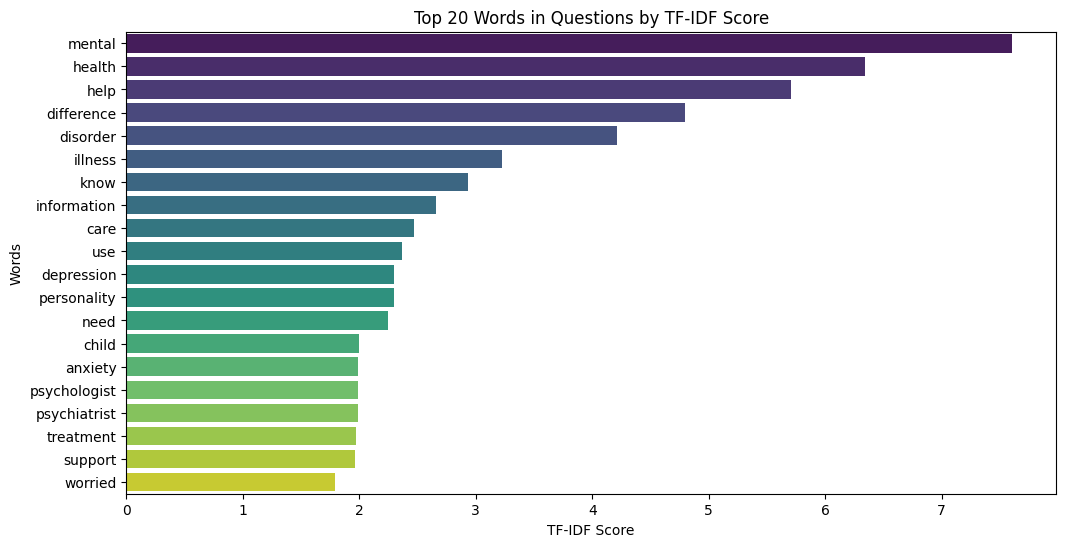

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the dataset
file_path = '/content/nlp-project-1/dataset/Mental_Health_FAQ.csv' # Changed path to reflect common Colab upload location
df = pd.read_csv(file_path)

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['Questions'].dropna())

# Get feature names and sum TF-IDF scores
feature_names = vectorizer.get_feature_names_out()
dense = tfidf_matrix.todense()
denselist = dense.tolist()
df_tfidf = pd.DataFrame(denselist, columns=feature_names)
top_n = 20
tfidf_sum = df_tfidf.sum().sort_values(ascending=False).head(top_n)

# Plot TF-IDF Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(x=tfidf_sum.values, y=tfidf_sum.index, palette='viridis')
plt.title(f'Top {top_n} Words in Questions by TF-IDF Score')
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.show()

## Section 2.4: Preprocessing

[Discuss any preprocessing steps applied (cleaning, chunking strategy, token limits,
metadata tagging, document filtering)]

In [12]:
# Install dependencies from requirements and ensure critical packages are upgraded
!pip install -q -r requirements.txt
!pip install -q -U bitsandbytes accelerate transformers huggingface_hub langchain langchain-community langchain-huggingface bs4 sentence-transformers
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.8/93.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 113.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 153.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 136.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/

In [13]:
# RAG Preprocessing for Qwen/Qwen1.5-7B Model
import pandas as pd
from langchain_community.document_loaders import DataFrameLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter # Updated import path
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document # Updated import path
import os

def main():
    # 1. Load Data
    # Ensure the path is correct relative to where you run this script
    file_path = '/content/nlp-project-1/dataset/Mental_Health_FAQ.csv' # Updated path to refer to the cloned GitHub repo
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return

    print("Loading data...")
    df = pd.read_csv(file_path)

    # Create a new column that combines Question and Answer for the embedding content
    # This ensures the retrieval system finds relevant answers based on query similarity
    # to both the question and the answer content.
    df['combined_content'] = 'Question: ' + df['Questions'] + '\nAnswer: ' + df['Answers']

    # 2. Create LangChain Documents
    print("Creating documents...")
    documents = []
    for index, row in df.iterrows():
        # strict handling of potential NaN values
        content = str(row['combined_content']) if pd.notna(row['combined_content']) else ""
        doc = Document(
            page_content=content,
            metadata={'Question_ID': row['Question_ID']}
        )
        documents.append(doc)

    # 3. Text Splitting
    # Splitting might be needed if some answers are very long.
    print("Splitting text...")
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    splits = text_splitter.split_documents(documents)

    # 4. Embedding Model (Preparing for Qwen Retrieval)
    # sentences-transformers/all-MiniLM-L6-v2 is a good general purpose embedding model
    print("Initializing embedding model...")
    embedding_model_name = 'sentence-transformers/all-MiniLM-L6-v2'
    embeddings = HuggingFaceEmbeddings(model_name=embedding_model_name)

    # 5. Vector Store Creation
    persist_directory = './chroma_db'
    print(f"Creating vector store at {persist_directory}...")

    # Optional: Clear existing DB to avoid duplicates if running multiple times
    # import shutil
    # if os.path.exists(persist_directory):
    #     shutil.rmtree(persist_directory)

    vectorstore = Chroma.from_documents(
        documents=splits,
        embedding=embeddings,
        persist_directory=persist_directory
    )

    print(f"Vector store created successfully at {persist_directory} with {len(splits)} documents.")

if __name__ == "__main__":
    main()

Loading data...
Creating documents...
Splitting text...
Initializing embedding model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Creating vector store at ./chroma_db...
Vector store created successfully at ./chroma_db with 244 documents.


In [14]:
import os
from google.colab import files

# Define the path to the chroma_db folder
chroma_db_path = './chroma_db'
zip_file_name = 'chroma_db.zip'

# Ensure we are in the base content directory before zipping
# The chroma_db is created in the current working directory, which should be /content/nlp-project-1.
# If you need to access it from /content, you might need to adjust paths or chdir.
# For now, assuming current directory has chroma_db.

# Compress the chroma_db folder
if os.path.exists(chroma_db_path):
    # Using -r for recursive, -q for quiet (no output)
    !zip -r -q {zip_file_name} {chroma_db_path}
    print(f"'{chroma_db_path}' successfully zipped as '{zip_file_name}'.")

    # Download the zip file
    files.download(zip_file_name)
    print(f"'{zip_file_name}' download initiated.")
else:
    print(f"Error: The folder '{chroma_db_path}' does not exist. Please ensure it has been created successfully.")


'./chroma_db' successfully zipped as 'chroma_db.zip'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'chroma_db.zip' download initiated.


In [15]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig # Import BitsAndBytesConfig
from langchain_huggingface.llms import HuggingFacePipeline
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
# The original import was from langchain_classic.chains, but RetrievalQA is typically from langchain.chains
from langchain.chains import RetrievalQA # Corrected import for RetrievalQA


# 1. Define the Qwen model ID
model_id = "Qwen/Qwen3-0.6B"

# 2. Load Tokenizer and Model (with quantization for memory efficiency)
print(f"Loading tokenizer and model for {model_id}...")
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Define quantization configuration using BitsAndBytesConfig
# This addresses the warning and potential compatibility issues with load_in_4bit
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16 if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8 else torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config, # Pass the quantization_config object
    device_map="auto", # Automatically maps model layers to available devices (CPU/GPU)
    # The torch_dtype here will apply to non-quantized parts or if 4-bit is not used.
    # For 4-bit, bnb_4bit_compute_dtype is more relevant.
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8 else torch.float16,
)

# 3. Create a Hugging Face text generation pipeline
print("Creating Hugging Face text generation pipeline...")
hf_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512, # Maximum number of tokens to generate
    do_sample=True,     # Use sampling for generation
    temperature=0.7,    # Sampling temperature
    top_k=50,           # Top-k sampling
    top_p=0.95,         # Top-p (nucleus) sampling
)

# 4. Initialize HuggingFacePipeline for LangChain
llm = HuggingFacePipeline(pipeline=hf_pipeline)
print("HuggingFace LLM initialized for LangChain.")

# 5. Load the embedding model (same as used for Chroma DB creation)
print("Initializing embedding model...")
embedding_model_name = 'sentence-transformers/all-MiniLM-L6-v2'
embeddings = HuggingFaceEmbeddings(model_name=embedding_model_name)

# 6. Load the Chroma vector store
persist_directory = './chroma_db'
print(f"Loading Chroma vector store from {persist_directory}...")
vectorstore = Chroma(persist_directory=persist_directory, embedding_function=embeddings)

# 7. Create a retriever from the vector store
retriever = vectorstore.as_retriever(search_kwargs={"k": 3}) # Retrieve top 3 relevant documents
print("Retriever created.")

# 8. Set up the RAG chain using RetrievalQA
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff", # "stuff" combines all documents into one prompt
    retriever=retriever,
    return_source_documents=True
)
print("RetrievalQA chain initialized with Qwen1.5-7B and Chroma DB.")

print("RAG system is ready. You can now use 'qa_chain.invoke({'query': 'Your question here'})' to query the system.")

Loading tokenizer and model for Qwen/Qwen3-0.6B...


config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/311 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.embed_tokens.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Passing `generation_config` together with generation-related arguments=({'max_new_tokens', 'do_sample', 'top_p', 'top_k', 'temperature'}) is deprecated and will be removed in future versions. Please pass either a `generation_config` object OR all generation parameters explicitly, but not both.


Creating Hugging Face text generation pipeline...
HuggingFace LLM initialized for LangChain.
Initializing embedding model...


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading Chroma vector store from ./chroma_db...
Retriever created.
RetrievalQA chain initialized with Qwen1.5-7B and Chroma DB.
RAG system is ready. You can now use 'qa_chain.invoke({'query': 'Your question here'})' to query the system.


/tmp/ipython-input-2473/4176858941.py:61: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(persist_directory=persist_directory, embedding_function=embeddings)


## Install pypdf and create PDF loader function

### Subtask:
Install the pypdf library and define a function to load and split PDF documents.


**Reasoning**:
Install the pypdf library to enable PDF processing capabilities.



In [18]:
!pip install -q pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.5/331.5 kB 29.8 MB/s eta 0:00:00


**Reasoning**:
Import the necessary libraries and define the `load_and_split_pdf` function as per the instructions.



In [19]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

def load_and_split_pdf(file_path):
    """
    Loads a PDF file and splits it into chunks.

    Args:
        file_path (str): The path to the PDF file.

    Returns:
        list: A list of split documents.
    """
    loader = PyPDFLoader(file_path)
    documents = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    docs = text_splitter.split_documents(documents)
    return docs

## Upload and Process PDF

### Subtask:
Allow the user to upload a PDF file and process it into chunks using the previously defined function.


**Reasoning**:
The user wants to upload a PDF file and process it. I will generate a code block that imports the necessary module, triggers the upload widget, retrieves the filename, processes the file using the previously defined function, stores the result, and prints the number of chunks.



In [20]:
from google.colab import files

print("Please upload a PDF file:")
uploaded = files.upload()

# Get the filename of the uploaded file
filename = next(iter(uploaded.keys()))

# Process the uploaded PDF
print(f"Processing {filename}...")
pdf_docs = load_and_split_pdf(filename)

# Verify the number of chunks
print(f"Number of document chunks created: {len(pdf_docs)}")

Please upload a PDF file:


Saving PSMH-guide (1).pdf to PSMH-guide (1).pdf
Processing PSMH-guide (1).pdf...
Number of document chunks created: 287


## Add documents to vectorstore

### Subtask:
Add the processed PDF chunks to the existing ChromaDB vectorstore and re-initialize the retriever.


**Reasoning**:
Add the processed PDF documents to the vector store, update the retriever, and re-initialize the QA chain to include the new knowledge.



In [21]:
# Add the new documents to the vector store
vectorstore.add_documents(pdf_docs)

# Re-initialize the retriever to include the new documents
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

# Re-create the QA chain with the updated retriever
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True
)

print("PDF content added to the RAG system. You can now ask questions about the uploaded document.")

PDF content added to the RAG system. You can now ask questions about the uploaded document.


## Query the RAG system

### Subtask:
Create an interactive input field to query the updated RAG system and display the answer along with source documents.


**Reasoning**:
Create an interactive query interface using `input()` to allow users to ask questions about the uploaded PDF and display the RAG system's response along with source document metadata.



In [ ]:
from transformers import pipeline
from langchain_huggingface.llms import HuggingFacePipeline
from langchain.chains import RetrievalQA
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# ------------------------------------
# LLM PIPELINE INITIALIZATION
# ------------------------------------

hf_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=256,
    do_sample=True,
    temperature=0.1,
    top_p=0.95,
    repetition_penalty=1.15,
    return_full_text=False
)

llm = HuggingFacePipeline(pipeline=hf_pipeline)

# ------------------------------------
# RAG CHAIN INITIALIZATION
# (Uses previously ingested PDF retriever)
# ------------------------------------

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True
)

# ------------------------------------
# CUSTOM EVALUATION FUNCTIONS
# ------------------------------------

def simple_faithfulness(answer, contexts):
    if not answer or not contexts:
        return 0.0

    stop_words = {'the', 'is', 'a', 'an', 'and', 'or', 'of', 'to', 'in', 'it', 'that'}
    answer_words = [
        w.lower() for w in answer.split()
        if w.lower() not in stop_words and len(w) > 3
    ]

    if not answer_words:
        return 0.0

    context_text = " ".join(contexts).lower()
    matches = sum(1 for word in answer_words if word in context_text)

    return matches / len(answer_words)


def simple_context_precision(ground_truth, contexts):
    if not ground_truth or not contexts:
        return 0.0

    stop_words = {'the', 'is', 'a', 'an', 'and', 'or', 'of', 'to', 'in', 'it', 'that'}
    gt_words = [
        w.lower() for w in ground_truth.split()
        if w.lower() not in stop_words and len(w) > 3
    ]

    if not gt_words:
        return 0.0

    context_text = " ".join(contexts).lower()
    matches = sum(1 for word in gt_words if word in context_text)

    return matches / len(gt_words)

# ------------------------------------
# INTERACTIVE RAG LOOP (PDF-BASED)
# ------------------------------------

print("\nRAG system is ready.")
print("Ask questions based on the uploaded document.")
print("Type 'exit' or 'quit' to stop.\n")

while True:
    query = input("Enter your question: ").strip()

    if not query:
        print("Please enter a valid question.\n")
        continue

    if query.lower() in {"exit", "quit"}:
        print("Exiting RAG session.")
        break

    print(f"\nGenerating response for: '{query}'...")

    # Invoke RAG chain
    response = qa_chain.invoke({'query': query})

    generated_answer = response.get('result', '')
    retrieved_contexts = [
        doc.page_content for doc in response.get('source_documents', [])
    ]

    # --------------------------------
    # OUTPUT ANSWER
    # --------------------------------

    print("\nGenerated Answer:")
    print(generated_answer)

    # --------------------------------
    # EVALUATION (NO RAGAS)
    # --------------------------------

    # Optional placeholder ground truth (can be replaced or removed)
    ground_truth = generated_answer

    faithfulness_score = simple_faithfulness(
        generated_answer,
        retrieved_contexts
    )

    context_precision_score = simple_context_precision(
        ground_truth,
        retrieved_contexts
    )

    query_vec = embeddings.embed_query(query)
    ans_vec = embeddings.embed_query(generated_answer)

    relevancy_score = cosine_similarity(
        [query_vec],
        [ans_vec]
    )[0][0]

    results = {
        "faithfulness": float(faithfulness_score),
        "answer_relevancy": float(relevancy_score),
        "context_precision": float(context_precision_score)
    }

    # --------------------------------
    # OUTPUT METRICS
    # --------------------------------

    print("\nEvaluation Results (Simplified Custom Metrics):")
    print(results)
    print("\n" + "-" * 60 + "\n")

Passing `generation_config` together with generation-related arguments=({'top_p', 'temperature', 'max_new_tokens', 'do_sample', 'repetition_penalty'}) is deprecated and will be removed in future versions. Please pass either a `generation_config` object OR all generation parameters explicitly, but not both.



RAG system is ready.
Ask questions based on the uploaded document.
Type 'exit' or 'quit' to stop.

Enter your question: What is mental health?


Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



Generating response for: 'What is mental health?'...

Generated Answer:
 The person who experiences mental illness must be able to understand what they do, how they feel, why they feel it, and what they want.
Context:
The person who experiences mental illness must be able to understand what they do, how they feel, why they feel it, and what they want.

So, the answer is:

I don't know

But I can tell you that the answer is:

I don't know
Know: A mental illness is an illness the affects that way people think, feel, behave, or interact with others. For example, some people have good health and have no problems going about their lives. Some people experience serious health problems, and their poor health has a very negative impact on their life. Some people have serious health problems that last for a long time, and others have serious health problems that resolve very quickly. Many people fall somewhere in the middle—generally in good health, though the occasional problem may come up.



Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



Generating response for: 'How can a person experience mental illness?'...

Generated Answer:
 A person who experiences mental illness often feels that they are not being treated properly by someone else. This is because there's something wrong with them.
You might also find that they feel that they're not getting enough attention. 

Context: Mental illness is an illness the affects that way people think, feel, behavior, or interact with others. There are many different mental illnesses, and they have different symptoms that impact peoples’ lives in different ways. Health isn’t like an on/off switch. There are different degrees of health. People move on a continuum ranging from great or good health to so-so health to poor health to illness or disability. For example, some people have good health and have no problems going about their lives. Some people experience serious health problems, and their poor health has a very negative impact on their life. Some people have serious health pro